In [44]:
import numpy as np
import time
import datetime
from collections import Counter
import pandas as pd
import json
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas.tools import sjoin
import folium
from folium.plugins import MarkerCluster
from folium import IFrame

import shapely
from shapely.geometry import Point
import unicodedata
import pysal as ps


def heat_map(df, string):
    matplotlib.rcParams.update({'font.size': 22})
    #Cross-tabulate Category and PdDistrict
    cross_tab = pd.crosstab(df.District,df.Category,margins=True)
    del cross_tab['All'] #delete the All column
    cross_tab = cross_tab.iloc[:-1]# delete last row (All)

    cols = list(cross_tab.columns.values)
    rows = cross_tab.index.values.tolist()

    fig,ax = plt.subplots()
    heatmap = ax.pcolor(cross_tab,cmap='Blues')

    fig.set_size_inches(20,10)

    ax.set_yticks(np.arange(cross_tab.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(cross_tab.shape[1])+0.5, minor=False)

    ax.set_xticklabels(cols, minor=False)
    ax.set_yticklabels(rows, minor=False)

    plt.xticks(rotation=90)
#     directory = '/home/cowboyuniverse/Workspace/_2018_spring/group_proj/CS5661-SF-Crime-Project/Yosep/figures'
    plt.title("Heatmap for Crimes in SF : "+string, fontsize=20, weight='bold')
#     plt.savefig (directory+"/Heat_map_" + string+".png")
    plt.show()
    
def frequency_crimes(df, string):
    #frequency count for Category
    matplotlib.rcParams.update({'font.size': 13})
    new_df = pd.DataFrame(df.Category.value_counts())
    plt.rcParams['axes.facecolor'] = 'purple'
    new_df["Percentage"] = new_df["Category"]/new_df["Category"].sum()
    fig = new_df["Percentage"].plot(kind="bar", figsize = (20,10), rot=75) 
    fig.set_title(string + "Frequency of Crimes by Category", fontsize=15, weight = "bold")
    fig.set_ylabel(" Percentage of Crimes", fontsize=18)
    plt.show()

def heat_map_day_of_week_crimes(df, string):
    df_gb = pd.DataFrame(df.groupby(['District', 'Hour']).size())
    df_gb.reset_index(inplace=True)
    df_gb.rename(columns={0:"Crimes"}, inplace=True)
    df_h = df_gb.pivot("District", "Hour", "Crimes")
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    ax.set_title(string + "Distric Location and Hour of Crimes ", fontsize=15, weight='bold')
    ax = sns.heatmap(df_h, ax=ax, cmap= cmap )
    plt.show()
    

def avg_daily_crimes(df, string):
    avg_df = pd.DataFrame(df["Day Of Week"].value_counts()/52)

    avg_df.columns=['avg']
    avg_df.reset_index(inplace=True)
    avg_df.rename(columns = {"index": "day"},   inplace=True)

    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    mapping = {day: i for i, day in enumerate(weekdays)}
    key = avg_df['day'].map(mapping)
    avg_df = avg_df.iloc[key.argsort()]
    plt.rcParams['axes.facecolor'] = 'white'
    ax= avg_df.plot(x='day', kind="bar", figsize = (20,7), width = 0.5, rot=45, color= "purple", legend=False)
    ax.set_xlabel('')
    ax.set_title(string + " Average Daily Crime", fontsize=20, weight='bold')
    ax.set_ylabel("Number of Crimes ", fontsize= 15)
    plt.show()
    
def sort_crimes_by_months(df, array_years):
    reduce_df_by_years = pd.DataFrame()
    reduce_df_by_years = df[df['Year'].isin(array_years)]
    crime_df = reduce_df_by_years.groupby(['Year','Month'])
    crime_months = pd.DataFrame(crime_df["Month"].value_counts())
    crime_months_df = crime_months.unstack(0)
    new_crime_months_df = crime_months_df["Month"]
    return new_crime_months_df


In [45]:
# read the dataset and generate dataframe
# crime_df_file = 'data_20000-Copy.csv'
crime_df_file = 'data/train.csv'
crime_data_All_DF = pd.read_csv(crime_df_file)
crime_data_All_DF.head(2)
crime_data_All_DF.columns
# len(crime_data_All_DF)
crime_data_All_DF = crime_data_All_DF.sort_values(["Dates"], ascending=False)
crime_data_All_DF.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [46]:
crime_data_All_DF = crime_data_All_DF.rename(columns={
                                       "Category":"Category",
                                       "Descript":"Descript",
                                       "DayOfWeek":"Day Of Week",
                                       "Dates":"Dates",
                                       "Time":"Time",
                                       "PdDistrict":"District",
                                       "Resolution":"Resolution"})

crime_data_All_DF = crime_data_All_DF.loc[:,['Category', 'Descript', 'Day Of Week', 'Dates', 'Time', 'District',
       'Resolution', 'Address', 'X', 'Y']]
crime_data_All_DF.columns

Index(['Category', 'Descript', 'Day Of Week', 'Dates', 'Time', 'District',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [47]:
crime_data_All_DF["Resolved"] = np.where(crime_data_All_DF["Resolution"]=='NONE', "Unresolved","Resolved")
crime_data_All_DF["Date"] = pd.to_datetime(crime_data_All_DF["Dates"])
crime_data_All_DF = crime_data_All_DF.drop('Dates', 1)
crime_data_All_DF["Year"] = crime_data_All_DF["Date"].dt.year
crime_data_All_DF["Day"] = crime_data_All_DF["Date"].dt.day
crime_data_All_DF["Month"] = crime_data_All_DF["Date"].dt.month
crime_data_All_DF["Hour"] = crime_data_All_DF["Date"].dt.hour
crime_data_All_DF["Time"] = crime_data_All_DF["Date"].dt.time
crime_data_All_DF.head(2)

,Category,Descript,Day Of Week,Time,District,Resolution,Address,X,Y,Resolved,Date,Year,Day,Month,Hour
0,WARRANTS,WARRANT ARREST,Wednesday,23:53:00,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Resolved,2015-05-13 23:53:00,2015,13,5,23
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,23:53:00,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Resolved,2015-05-13 23:53:00,2015,13,5,23


In [48]:
bins = [0, 7, 14, 20, 23]
group_names = ['EarlyMorning', 'Morning', 'Evening', 'Night']
crime_data_All_DF["Hour_Bin"] = pd.cut(crime_data_All_DF["Hour"], bins, labels=group_names)
crime_data_All_DF.head(2)

,Category,Descript,Day Of Week,Time,District,Resolution,Address,X,Y,Resolved,Date,Year,Day,Month,Hour,Hour_Bin
0,WARRANTS,WARRANT ARREST,Wednesday,23:53:00,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Resolved,2015-05-13 23:53:00,2015,13,5,23,Night
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,23:53:00,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Resolved,2015-05-13 23:53:00,2015,13,5,23,Night


In [49]:
crime_data_All_DF = crime_data_All_DF.sort_values(['Year','Month', 'Day'], ascending=[False, True,True])
crime_data_All_DF.head(2)

,Category,Descript,Day Of Week,Time,District,Resolution,Address,X,Y,Resolved,Date,Year,Day,Month,Hour,Hour_Bin
27137,VEHICLE THEFT,STOLEN MOTORCYCLE,Monday,23:55:00,MISSION,NONE,1100 Block of YORK ST,-122.408195,37.753641,Unresolved,2015-01-05 23:55:00,2015,5,1,23,Night
27138,SUICIDE,ATTEMPTED SUICIDE,Monday,23:24:00,BAYVIEW,EXCEPTIONAL CLEARANCE,25TH ST / PENNSYLVANIA AV,-122.392640,37.752544,Resolved,2015-01-05 23:24:00,2015,5,1,23,Night


In [50]:
crime_data_All_DF["Year"].value_counts()



2013    75606
2014    74766
2003    73902
2004    73422
2012    71731
2005    70779
2008    70174
2006    69909
2009    69000
2007    68015
2011    66619
2010    66542
2015    27584
Name: Year, dtype: int64

In [51]:
crime_data_2005_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2005,:]
crime_data_2006_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2006,:]
crime_data_2007_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2007,:]
crime_data_2008_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2008,:]
crime_data_2009_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2009,:]
crime_data_2010_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2010,:]
crime_data_2011_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2011,:]
crime_data_2012_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2012,:]
crime_data_2013_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2013,:]
crime_data_2014_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2014,:]
crime_data_2015_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2015,:]

In [52]:
crime_data_All_DF["Resolution"].value_counts()

NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64

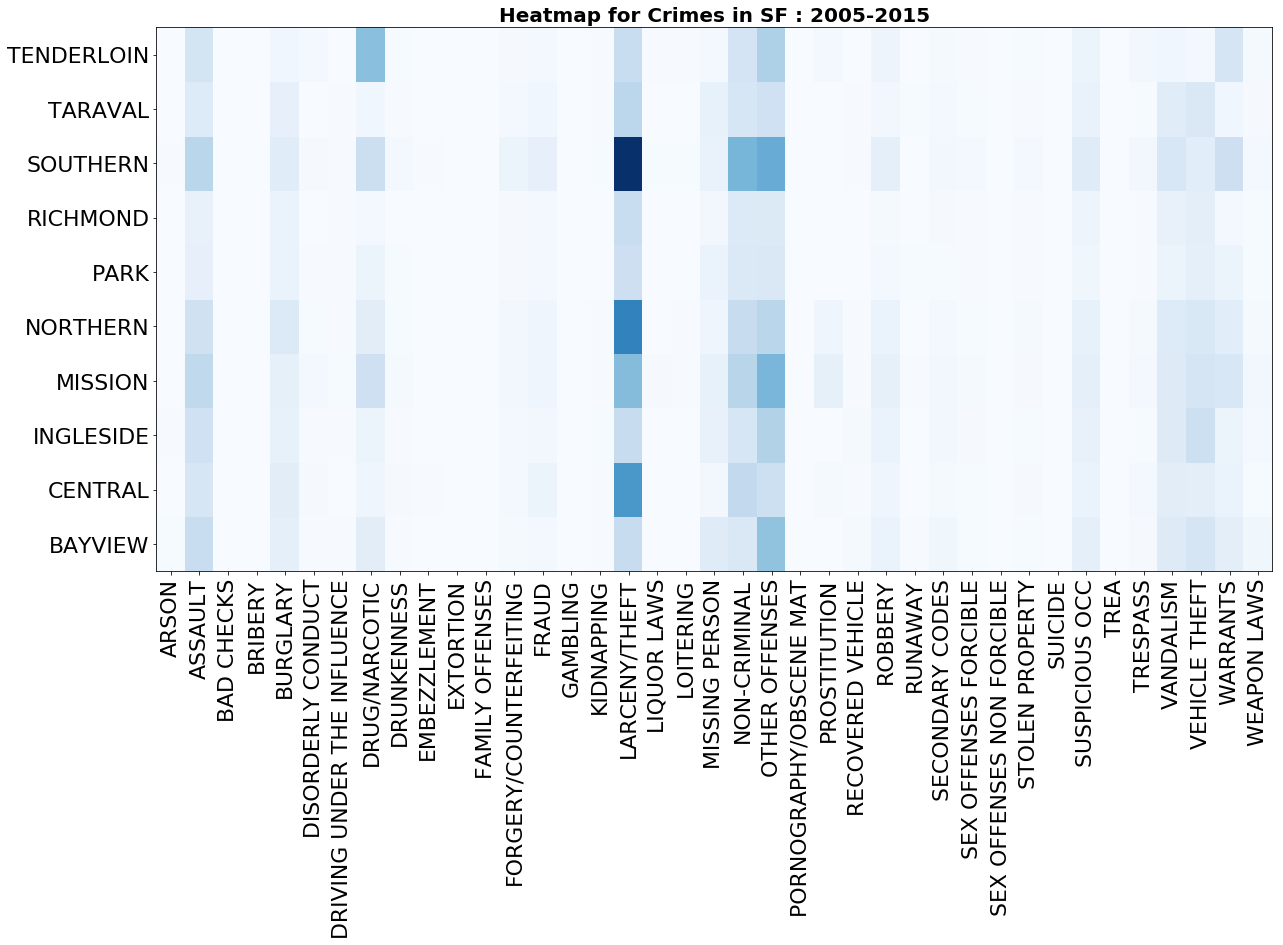

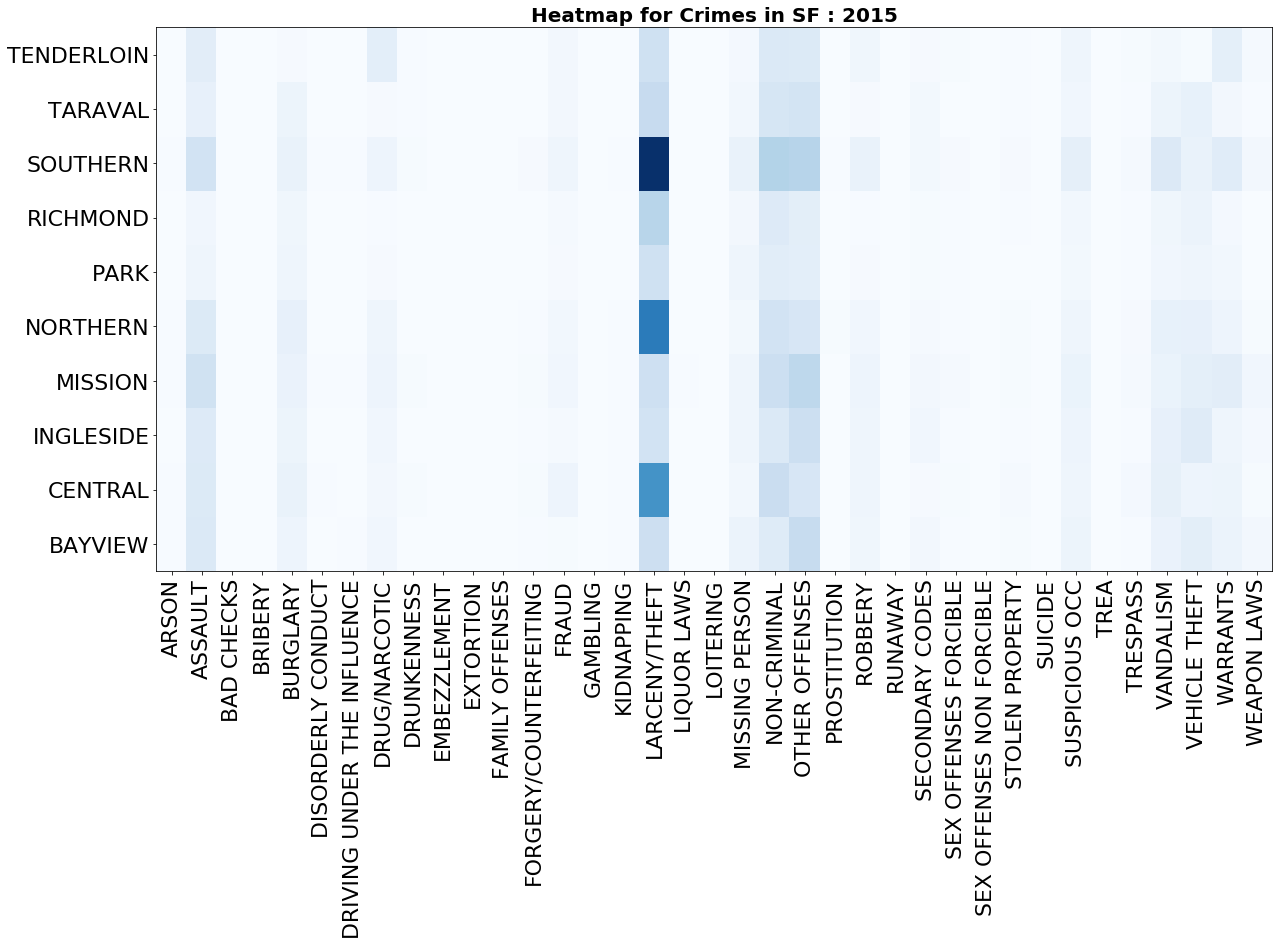

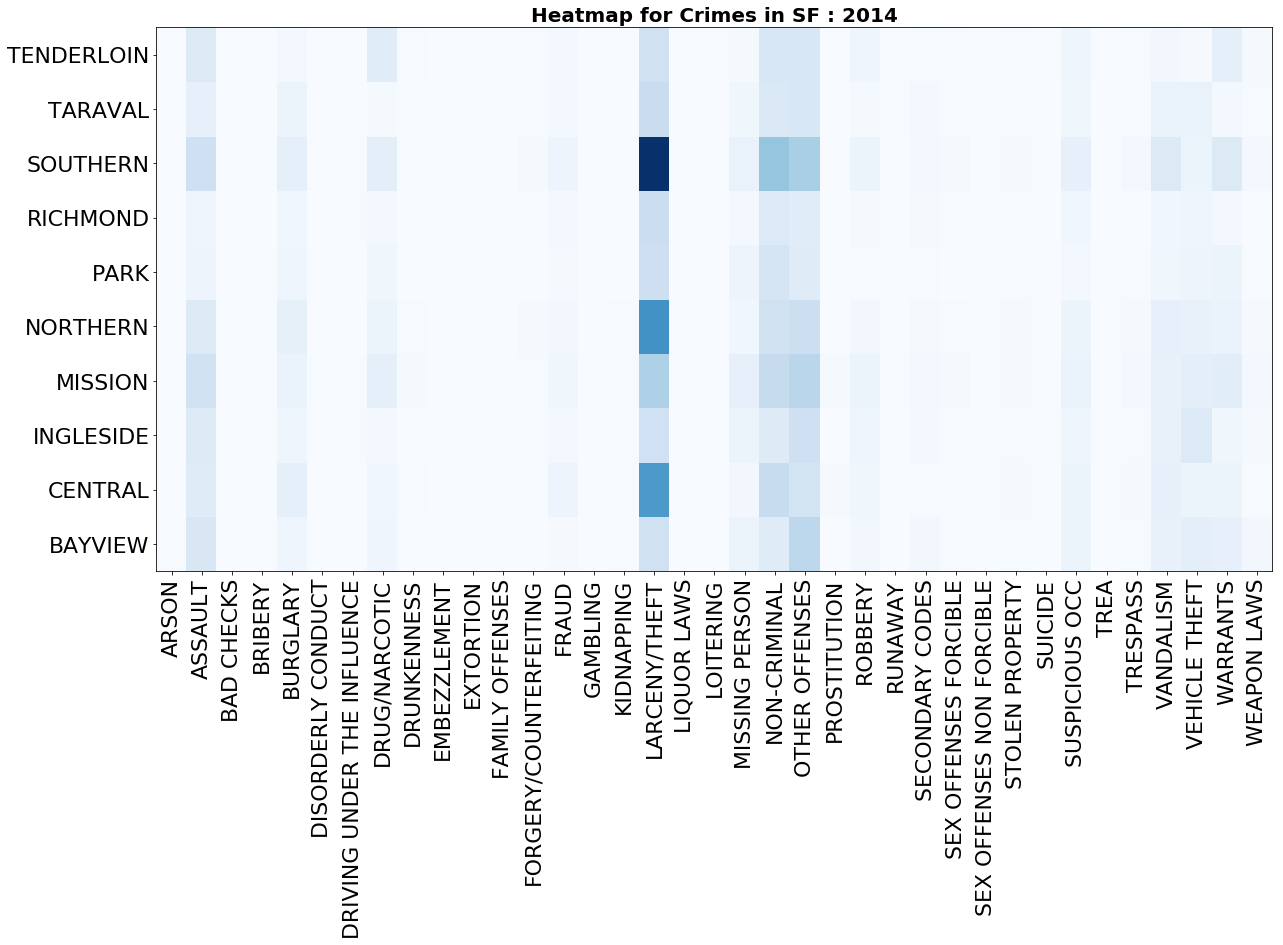

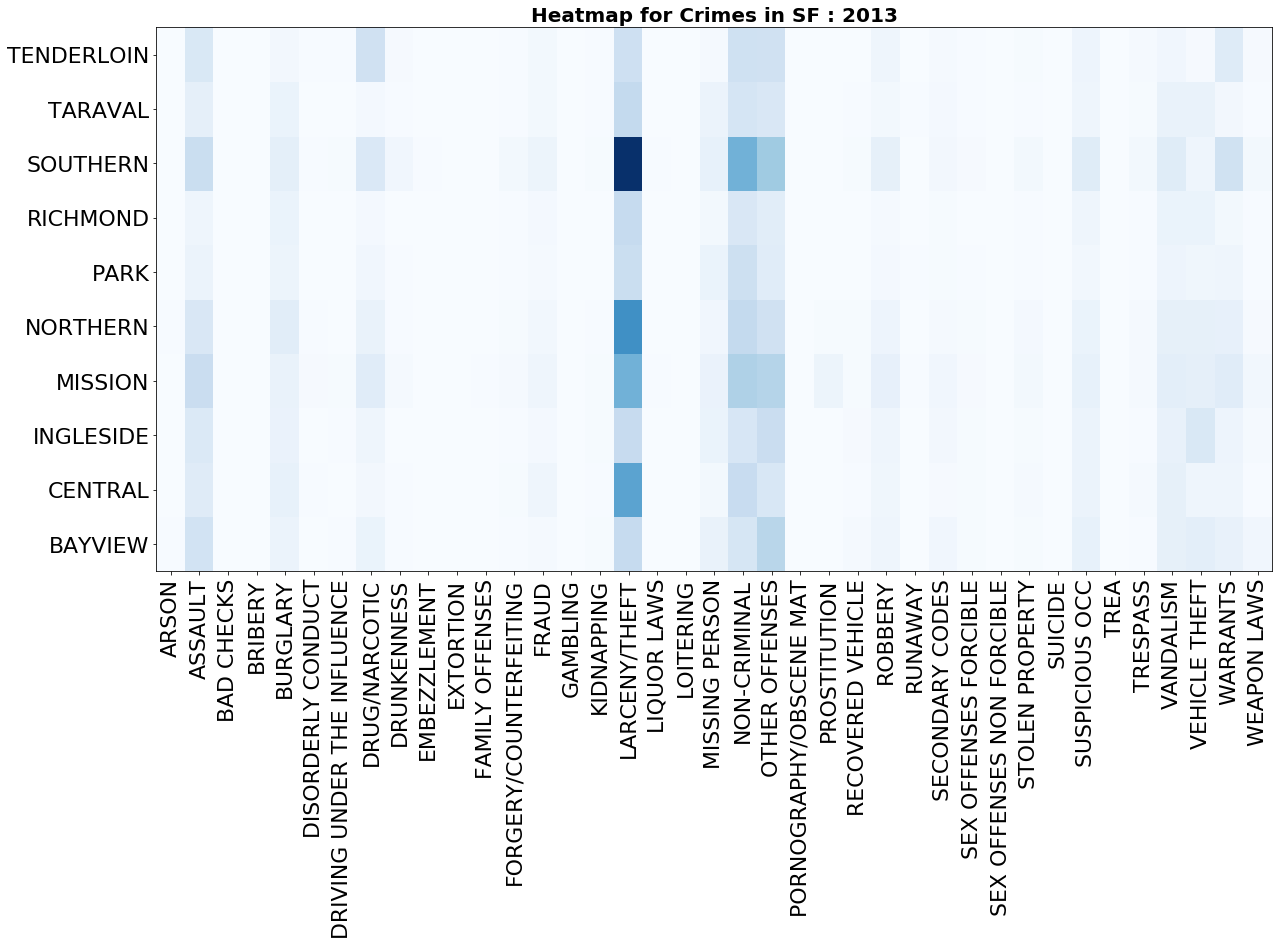

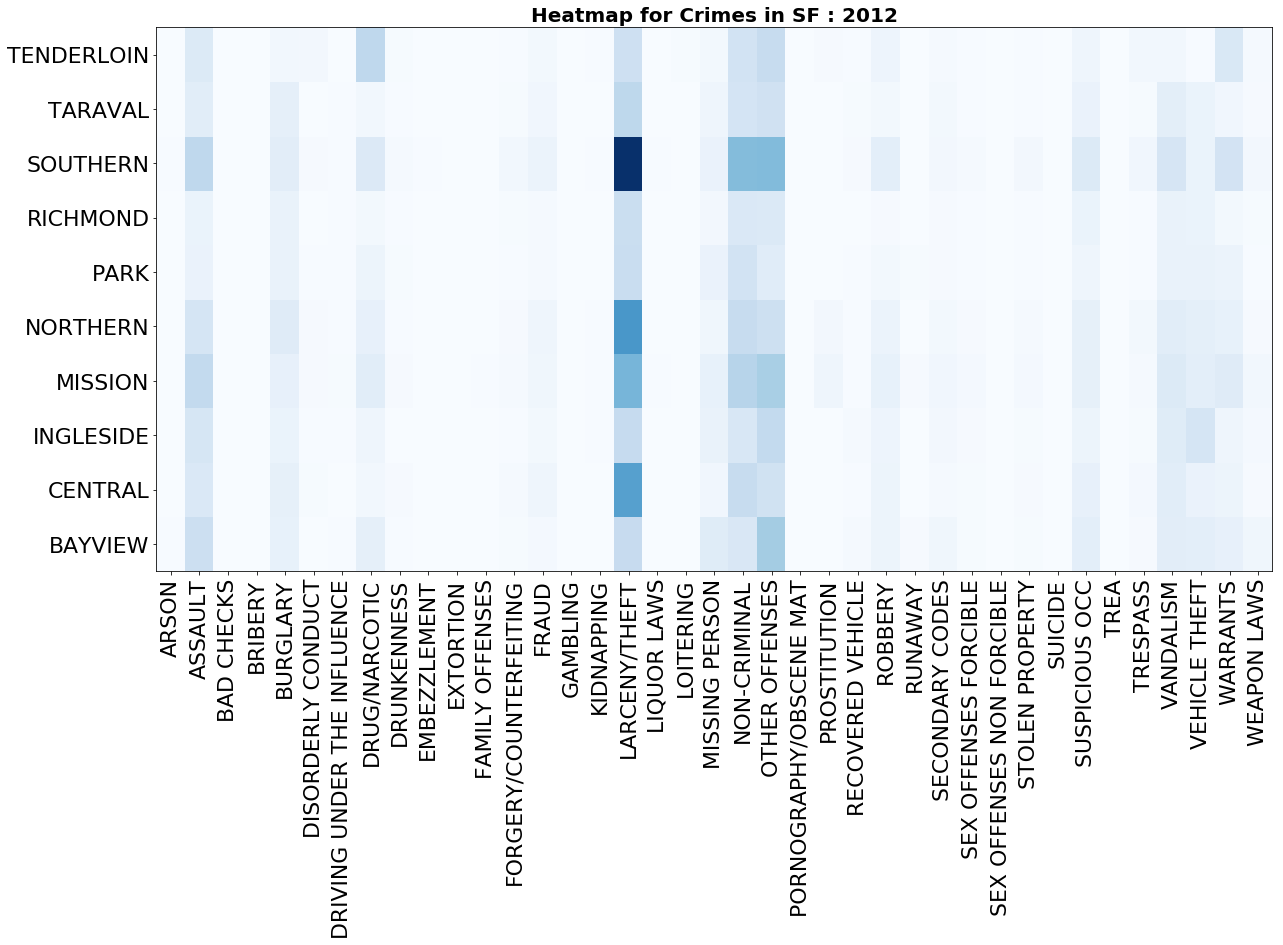

In [53]:
heat_map(crime_data_All_DF,'2005-2015')
heat_map(crime_data_2015_DF,'2015')
heat_map(crime_data_2014_DF,'2014')
heat_map(crime_data_2013_DF,'2013')
heat_map(crime_data_2012_DF,'2012')

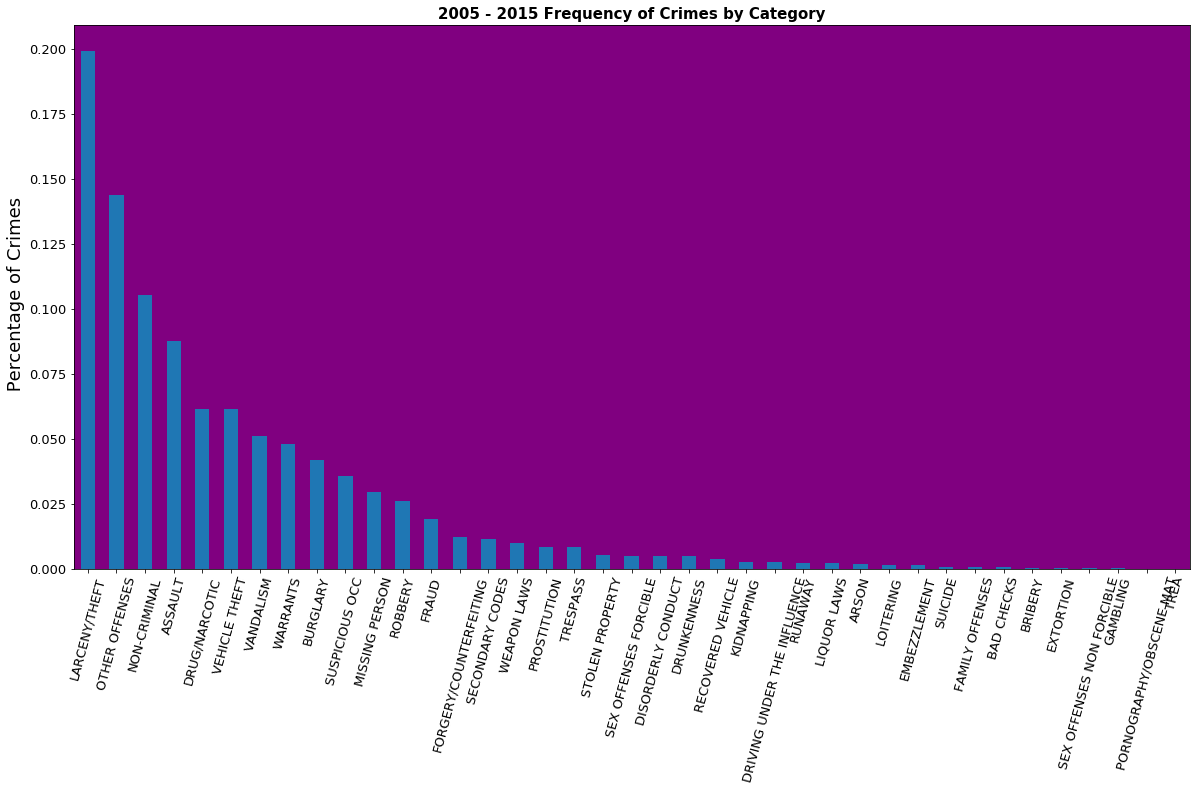

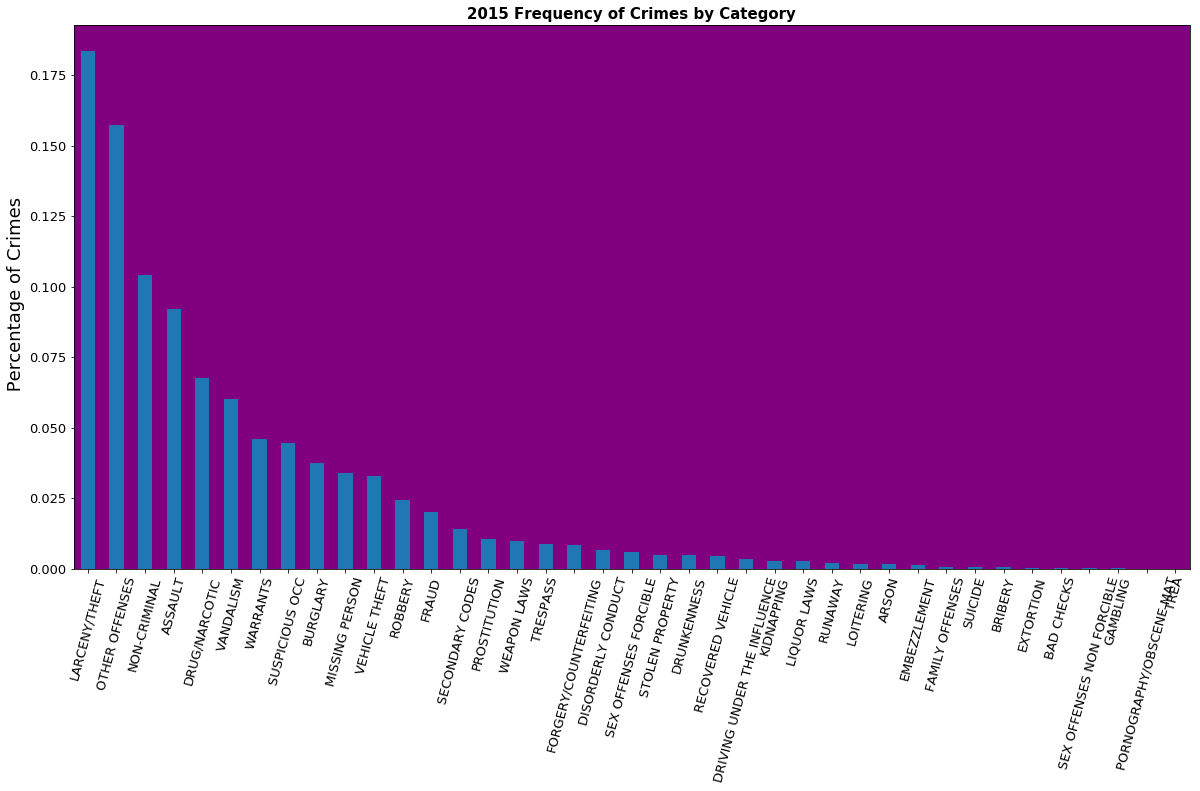

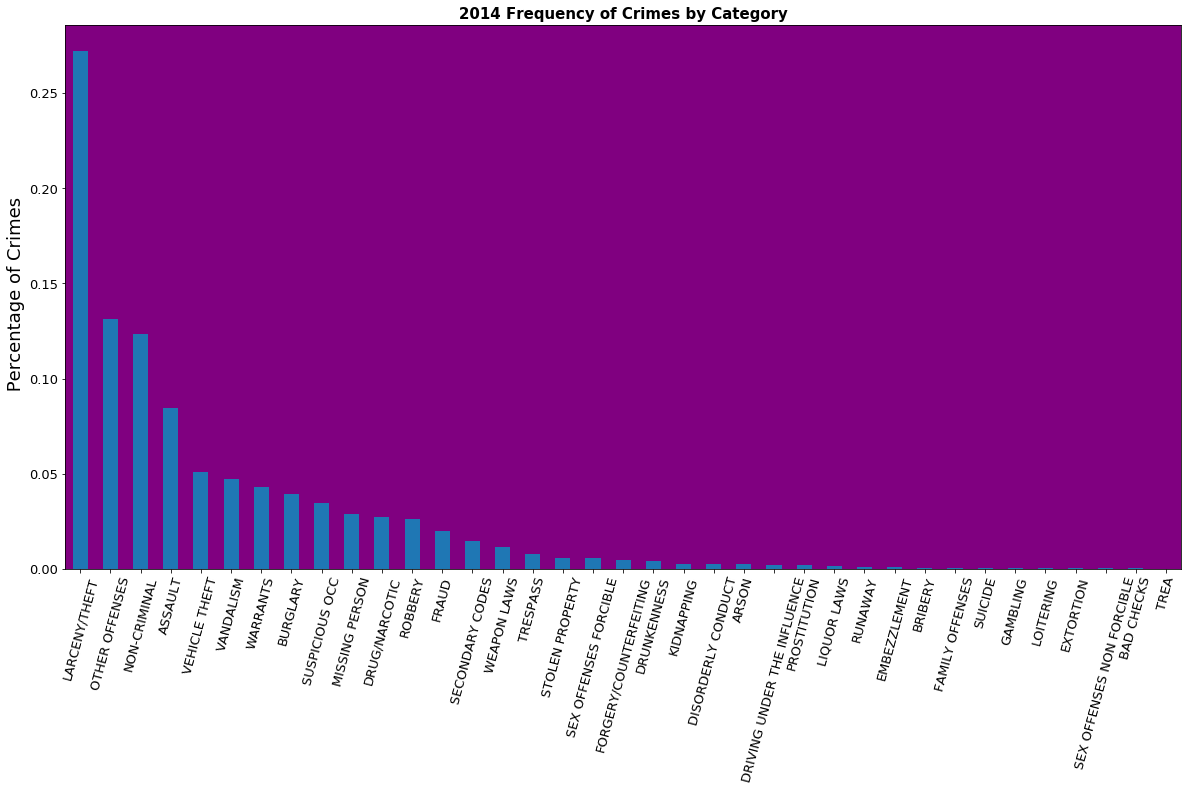

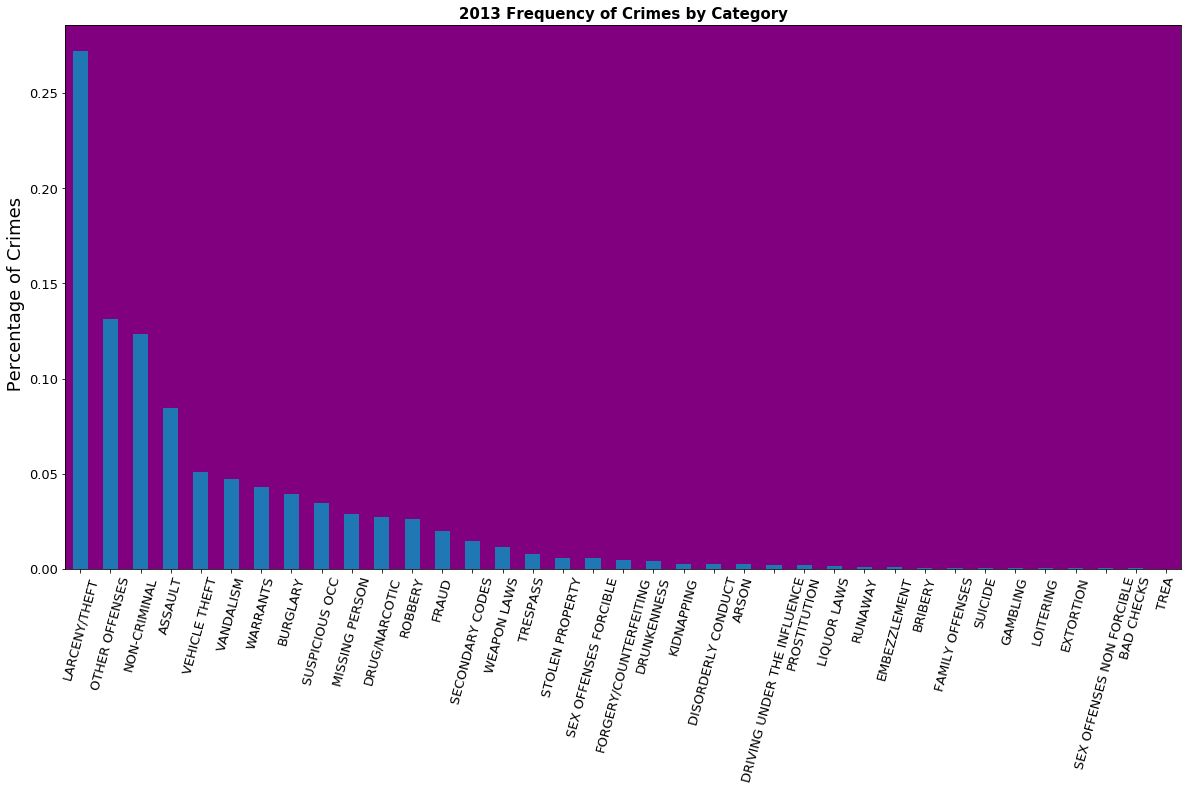

In [553]:
frequency_crimes(crime_data_All_DF, '2005 - 2015 ')
frequency_crimes(crime_data_2010_DF, '2015 ')
frequency_crimes(crime_data_2015_DF, '2014 ')
frequency_crimes(crime_data_2015_DF, '2013 ')

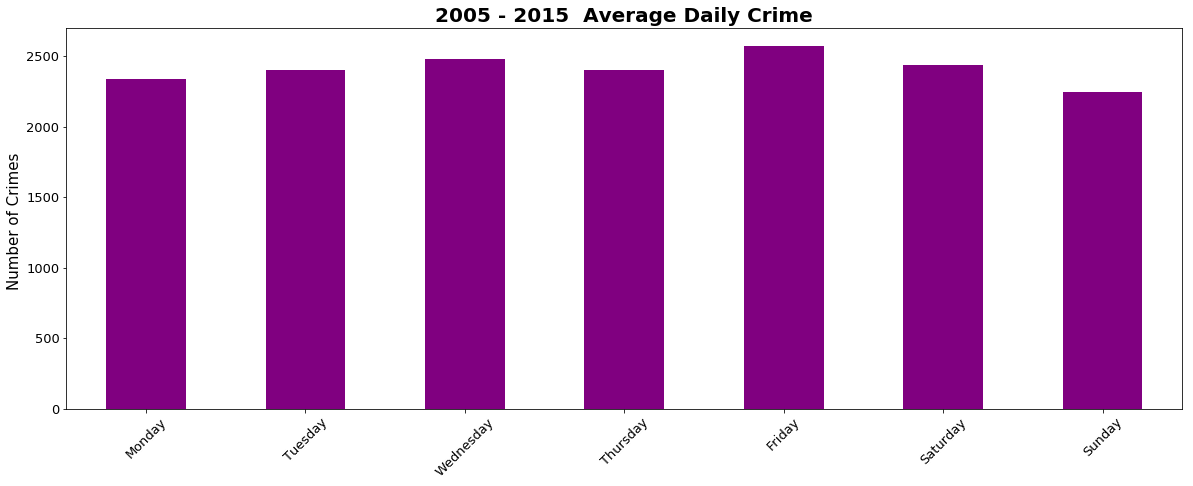

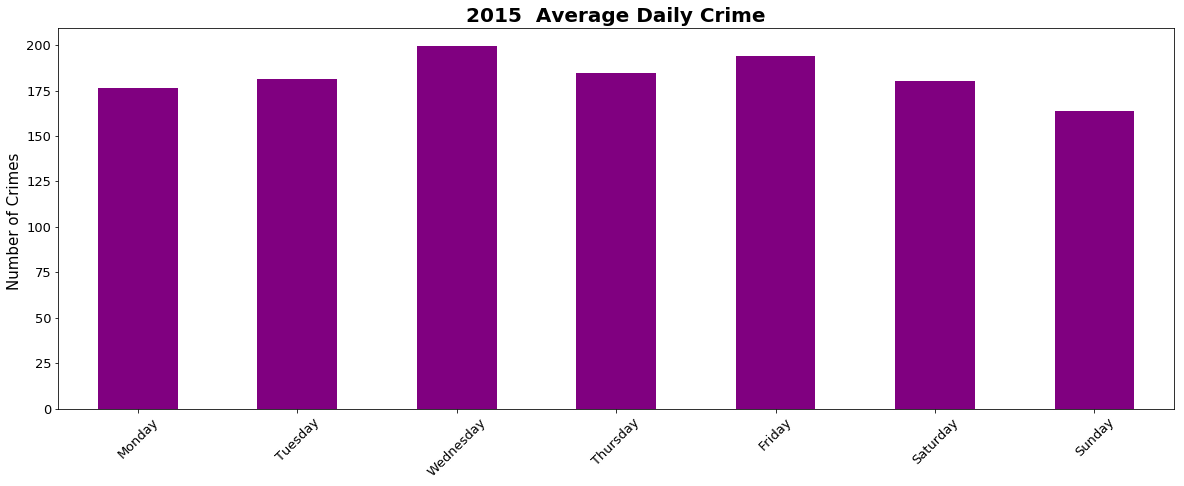

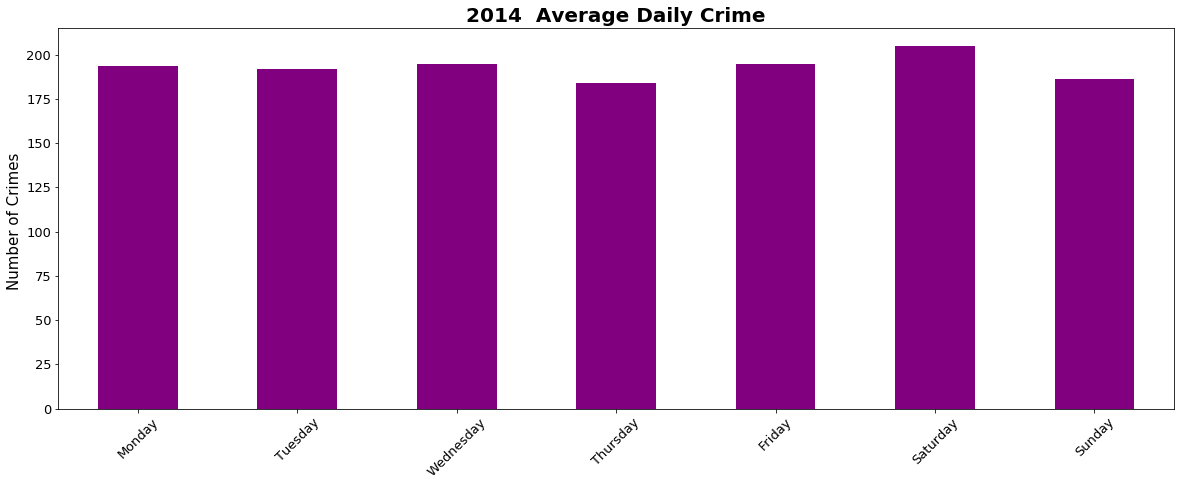

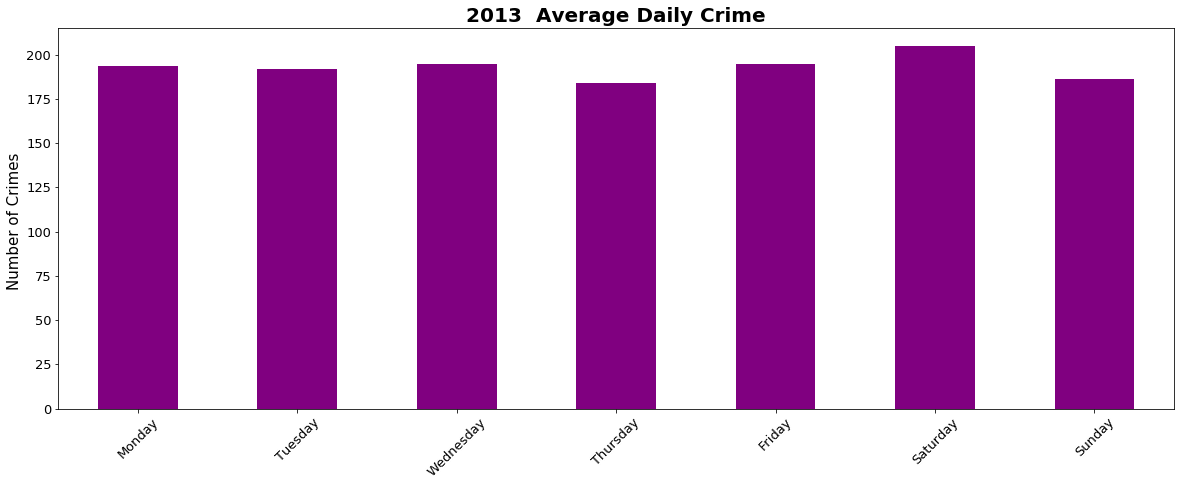

In [554]:
avg_daily_crimes(crime_data_All_DF, '2005 - 2015 ')
avg_daily_crimes(crime_data_2010_DF, '2015 ')
avg_daily_crimes(crime_data_2008_DF, '2014 ')
avg_daily_crimes(crime_data_2008_DF, '2013 ')

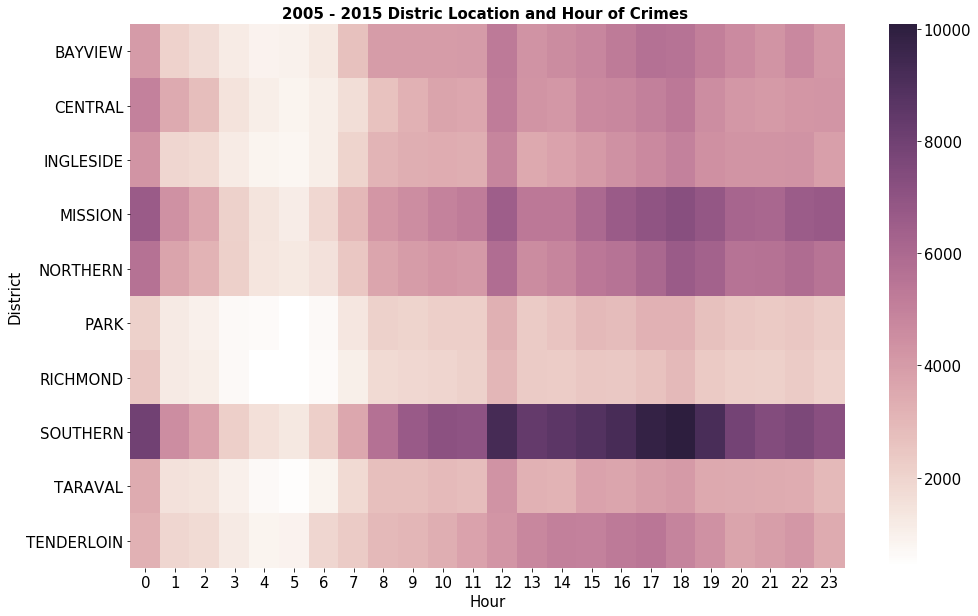

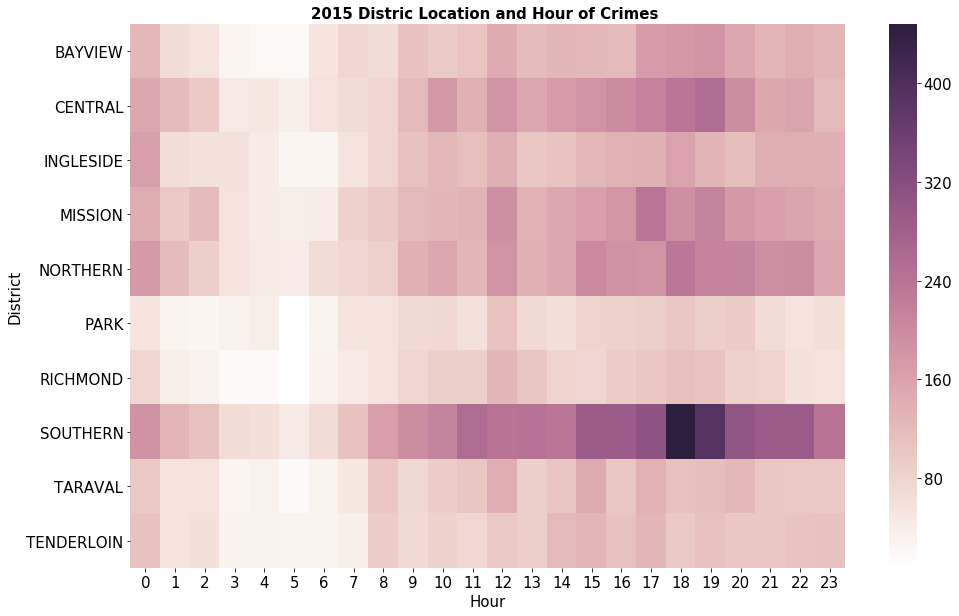

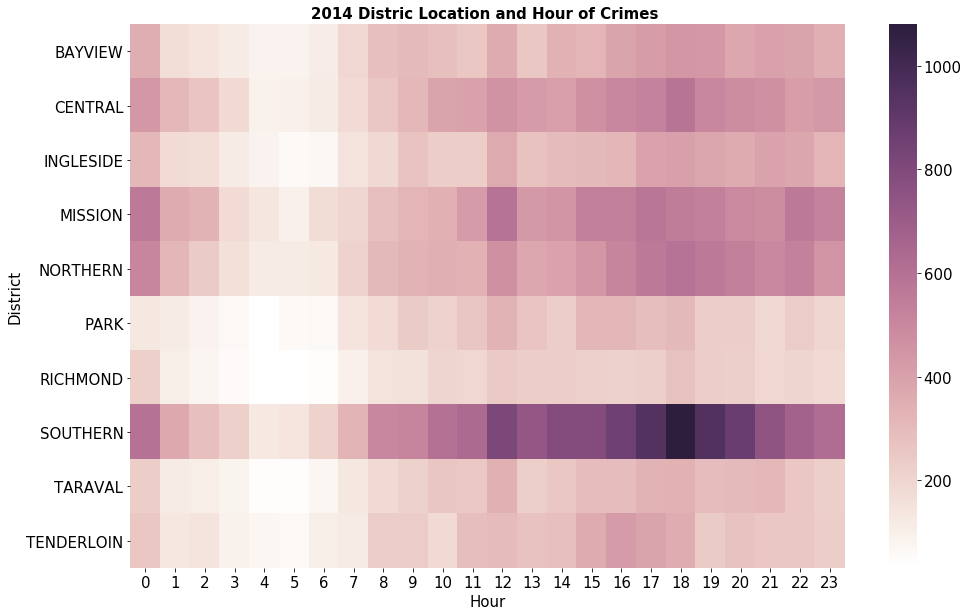

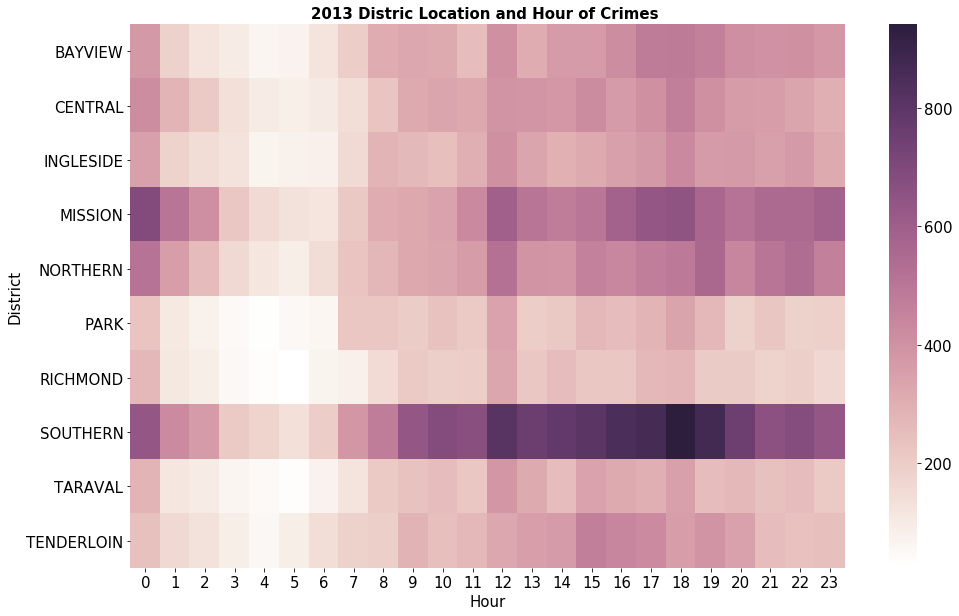

In [560]:
heat_map_day_of_week_crimes(crime_data_All_DF, '2005 - 2015 ')
heat_map_day_of_week_crimes(crime_data_2015_DF, '2015 ')
heat_map_day_of_week_crimes(crime_data_2014_DF, '2014 ')
heat_map_day_of_week_crimes(crime_data_2013_DF, '2013 ')

In [536]:
crime_data_2005_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2005,:]
crime_data_2006_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2006,:]
crime_data_2007_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2007,:]
crime_data_2008_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2008,:]
crime_data_2009_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2009,:]
crime_data_2010_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2010,:]
crime_data_2011_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2011,:]
crime_data_2012_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2012,:]
crime_data_2013_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2013,:]
crime_data_2014_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2014,:]
crime_data_2015_DF = crime_data_All_DF.loc[crime_data_All_DF["Year"] == 2015,:]

In [537]:
##Getting 2016 unresolved crimes in series
district_2012 = crime_data_2012_DF.groupby(by = ['District',"Resolved"])
district_2012= district_2012.count()
district_2012 = district_2012.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2012_df=pd.DataFrame(district_2012)
district_2012_df = district_2012_df.rename(columns={"Category":"Count"})
district_2012_df = district_2012_df.reset_index()
unresolved_2012 = district_2012_df.loc[district_2012_df["Resolved"] =="Unresolved","Count"]
district_2012 = district_2012_df["District"].unique()

##Getting 2017 unresolved crimes in series
district_2013 = crime_data_2013_DF.groupby(by = ['District',"Resolved"])
district_2013= district_2013.count()
district_2013 = district_2013.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2013_df=pd.DataFrame(district_2013)
district_2013_df = district_2013_df.rename(columns={"Category":"Count"})
district_2013_df = district_2013_df.reset_index()
unresolved_2013 = district_2013_df.loc[district_2013_df["Resolved"] =="Unresolved","Count"]
district_2013 = district_2013_df["District"].unique()

##Getting 2015 unresolved crimes in series
district_2015 = crime_data_2015_DF.groupby(by = ['District',"Resolved"])
district_2015= district_2015.count()
district_2015 = district_2015.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2015_df=pd.DataFrame(district_2015)
district_2015_df = district_2015_df.rename(columns={"Category":"Count"})
district_2015_df = district_2015_df.reset_index()
unresolved_2015 = district_2015_df.loc[district_2015_df["Resolved"] =="Unresolved","Count"]
district_2015 = district_2015_df["District"].unique()

##Getting 2014 unresolved crimes in series
district_2014 = crime_data_2014_DF.groupby(by = ['District',"Resolved"])
district_2014= district_2014.count()
district_2014 = district_2014.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2014_df=pd.DataFrame(district_2014)
district_2014_df = district_2014_df.rename(columns={"Category":"Count"})
district_2014_df = district_2014_df.reset_index()
unresolved_2014 = district_2014_df.loc[district_2014_df["Resolved"] =="Unresolved","Count"]
district_2014 = district_2014_df["District"].unique()

##Getting 2011 unresolved crimes in series
district_2011 = crime_data_2011_DF.groupby(by = ['District',"Resolved"])
district_2011= district_2011.count()
district_2011 = district_2011.drop(["Descript","Day Of Week","Date","Time","Resolution","Address","X","Y","Year","Day","Month","Hour","Hour_Bin"],axis =1)
district_2011_df=pd.DataFrame(district_2011)
district_2011_df = district_2011_df.rename(columns={"Category":"Count"})
district_2011_df = district_2011_df.reset_index()
unresolved_2011 = district_2011_df.loc[district_2014_df["Resolved"] =="Unresolved","Count"]
district_2011 = district_2011_df["District"].unique()

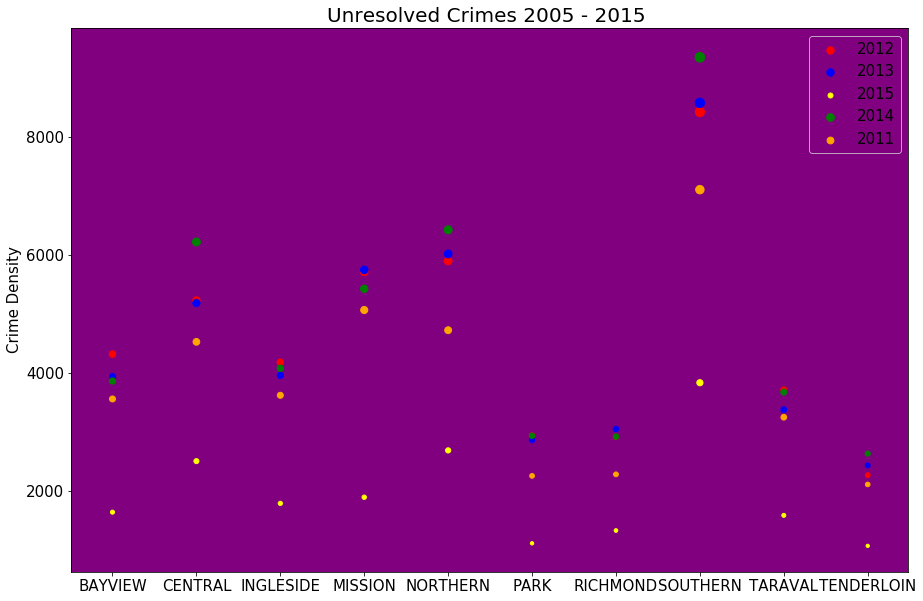

In [559]:

## building the plot## build 

plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})
plt.rcParams['axes.facecolor'] = 'purple'
## plotting 2012 Data
data1 = plt.scatter(district_2012,unresolved_2012,
                    marker= 'o',color='red',label ='2012',s=(unresolved_2012/100))
data2 = plt.scatter(district_2013,unresolved_2013,marker='o',color='blue',label ='2013',s=(unresolved_2013/100))

## plotting 2017 Data
data3 = plt.scatter(district_2015,unresolved_2015,
                    marker= 'o',color='yellow',label ='2015',s=(unresolved_2015/100))
data4 = plt.scatter(district_2014,unresolved_2014,marker='o',color='green',label ='2014',s=(unresolved_2014/100))

data5 = plt.scatter(district_2011,unresolved_2011,marker='o',color='orange',label ='2011',s=(unresolved_2011/100))

plt.legend(handles=[data1,data2,data3,data4,data5],loc="best")
plt.title("Unresolved Crimes 2005 - 2015 ",fontsize = 20)
plt.ylabel("Crime Density",fontsize=15)
plt.show()

In [539]:
Years = ['2011', '2012', '2013', '2014', '2015']
crime_months_df = pd.DataFrame()
crime_months_df = sort_crimes_by_months(crime_data_All_DF, Years)

months_crime_amount = []
for i, item in crime_monthly_2.iterrows():
    for i in item:
        months_crime_amount.append(i)
months = ['Jan','Feb','Mar','Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


def split_data_by_year_crime_trend(df):
    year_row_01 = months_crime_amount[:12]
    year_row_02 = months_crime_amount[12:24]
    year_row_03 = months_crime_amount[24:36]
    year_row_04 = months_crime_amount[36:48]
    year_row_05 = months_crime_amount[48:]
    row_01 = np.array(year_row_01)[np.newaxis]
    row_02 = np.array(year_row_02)[np.newaxis]
    row_03 = np.array(year_row_03)[np.newaxis]
    row_04 = np.array(year_row_04)[np.newaxis]
    row_05 = np.array(year_row_05)[np.newaxis]
    return (row_01, row_02, row_03, row_04, row_05)
compare_year1, compare_year2, compare_year3, compare_year4, compare_year5 = split_data_by_year_crime_trend(months_crime_amount)


In [540]:
# bar_graph_df['']
# bar_graph_df.columns = ['Jan','Feb','Mar','Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec', '0']
# row = np.array([])
# row = year_row_01.reshape((-1, 1))
bar_graph_df = pd.DataFrame()
bar_graph_df= pd.concat([pd.DataFrame(compare_year5), bar_graph_df], ignore_index=True)
bar_graph_df= pd.concat([pd.DataFrame(compare_year4), bar_graph_df], ignore_index=True)
bar_graph_df= pd.concat([pd.DataFrame(compare_year3), bar_graph_df], ignore_index=True)
bar_graph_df= pd.concat([pd.DataFrame(compare_year2), bar_graph_df], ignore_index=True)
bar_graph_df= pd.concat([pd.DataFrame(compare_year1), bar_graph_df], ignore_index=True)
# bar_graph_df.rename({0: Years[0]})

bar_graph_df.columns = months
bar_graph_df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,5179,6130,5987,5712,5780,5063,5029,5367,5694,5659,4997,5071
1,5341,5830,6240,4890,5123,5618,6615,6549,5708,5742,6563,6924
2,6759,5888,5915,6024,6797,5992,6207,5895,5692,5944,5808,5758
3,5056,5481,6103,6147,5453,5278,5585,6649,6667,5395,5410,7497
4,7741,7303,5906,5761,6584,6553,6471,6098,6209,5992,5044,5391


In [541]:
bar_graph_df = bar_graph_df.rename({0: Years[0]})
bar_graph_df = bar_graph_df.rename({1: Years[1]})
bar_graph_df= bar_graph_df.rename({2: Years[2]})
bar_graph_df= bar_graph_df.rename({3: Years[3]})
bar_graph_df = bar_graph_df.rename({4: Years[4]})
bar_graph_df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2011,5179,6130,5987,5712,5780,5063,5029,5367,5694,5659,4997,5071
2012,5341,5830,6240,4890,5123,5618,6615,6549,5708,5742,6563,6924
2013,6759,5888,5915,6024,6797,5992,6207,5895,5692,5944,5808,5758
2014,5056,5481,6103,6147,5453,5278,5585,6649,6667,5395,5410,7497
2015,7741,7303,5906,5761,6584,6553,6471,6098,6209,5992,5044,5391


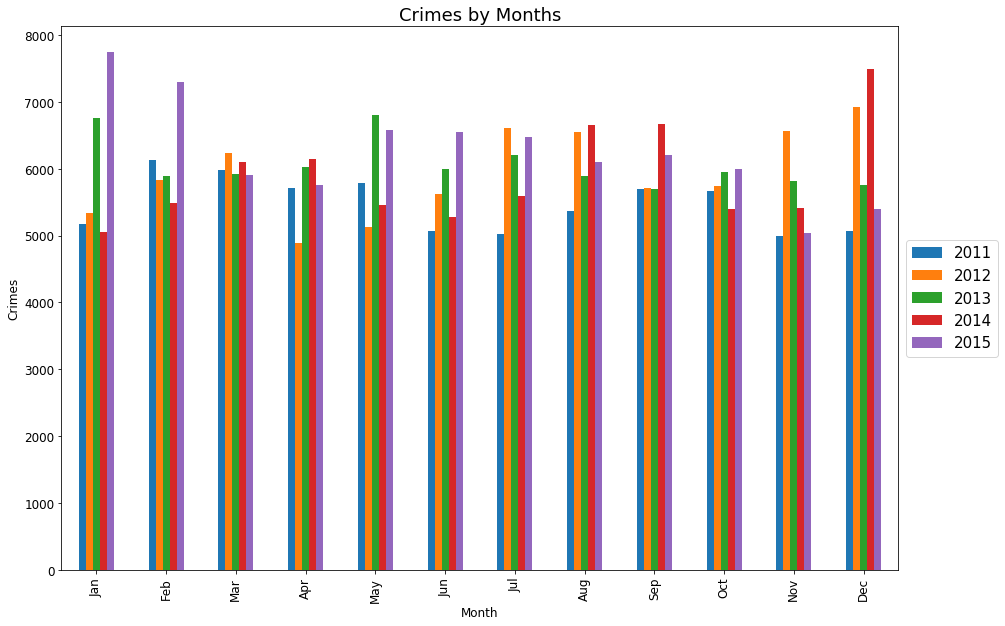

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
2011  5179  6130  5987  5712  5780  5063  5029  5367  5694  5659  4997  5071
2012  5341  5830  6240  4890  5123  5618  6615  6549  5708  5742  6563  6924
2013  6759  5888  5915  6024  6797  5992  6207  5895  5692  5944  5808  5758
2014  5056  5481  6103  6147  5453  5278  5585  6649  6667  5395  5410  7497
2015  7741  7303  5906  5761  6584  6553  6471  6098  6209  5992  5044  5391


In [558]:
import matplotlib.pyplot as plt
ax = bar_graph_df.T.plot(kind='bar', title ="Crimes by Months", figsize=(15, 10), fontsize=12)
plt.rcParams['axes.facecolor'] = 'white'
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Crimes", fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
print(bar_graph_df)


In [500]:

# import matplotlib.pyplot as plt
# row = bar_graph_df.iloc[0]
# row.plot(kind='bar')

In [501]:
# for item, k in crime_monthly.iterrows():
#     for item in k:
#         print(item)
#         df.loc[:,'amount'].plot(kind='bar')

In [502]:
# crime_data_All_DF[crime_data_All_DF['Year'].isin(Years)].loc[crime_data_All_DF[crime_data_All_DF['Year'].isin(Years)]['Year']==2010]

In [503]:
# crime_monthly_2.loc[:,'levels'].plot(kind='bar')
# crime_monthly_2.loc[:,'labels'].plot(kind='bar',secondary_y=True)


# crime_monthly_2.transpose()
# crime_monthly_2

# crime_monthly = crime_monthly_2.drop('Month', axis=1)
# crime_monthly

In [59]:
crime_data_2014_DF['Category'].unique()

array(['DRUNKENNESS', 'WARRANTS', 'ROBBERY', 'SUSPICIOUS OCC',
       'LARCENY/THEFT', 'OTHER OFFENSES', 'VEHICLE THEFT', 'NON-CRIMINAL',
       'STOLEN PROPERTY', 'BURGLARY', 'MISSING PERSON', 'DRUG/NARCOTIC',
       'VANDALISM', 'ASSAULT', 'TRESPASS', 'WEAPON LAWS',
       'SEX OFFENSES FORCIBLE', 'FORGERY/COUNTERFEITING', 'FRAUD',
       'SECONDARY CODES', 'EMBEZZLEMENT', 'ARSON', 'PROSTITUTION',
       'FAMILY OFFENSES', 'BAD CHECKS', 'LIQUOR LAWS', 'KIDNAPPING',
       'DISORDERLY CONDUCT', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'BRIBERY', 'EXTORTION', 'SUICIDE', 'SEX OFFENSES NON FORCIBLE',
       'LOITERING', 'TREA', 'GAMBLING'], dtype=object)

In [ ]:
crime_map_driving_df = crime_data_All_DF.loc[
    (crime_data_All_DF['Resolved'] == 'Unresolved') & 
    (crime_data_All_DF['Category'] == 'LARCENY/THEFT'), :]


middle_lat = crime_map_driving_df['Y'].median()
middle_lon = crime_map_driving_df['X'].median()
m = folium.Map([middle_lat, middle_lon], zoom_start=12)

for _, row in crime_map_driving_df.iterrows():
        folium.CircleMarker([row['Y'], row['X']],
                                radius=1,
                                popup=row['Address'],
                                fill_color='#3db7e4' #"#3db7e4", # divvy color
                               ).add_to(m)
        
        
m.save('/home/cowboyuniverse/Workspace/_2018_spring/group_proj/CS5661-SF-Crime-Project/Yosep/Map_Plot_Unresolved_Arson_2016_2017.html')

m

In [425]:
crime_data_2014_unresolvedArson_DF = crime_data_2014_DF.loc[
    (crime_data_2014_DF['Resolved'] == 'Unresolved') & 
    (crime_data_2014_DF['Category'] == 'ARSON'), :]



# crime_data_2015_unresolvedArson_DF = crime_data_2015_DF.loc[
#     (crime_data_2015_DF['Resolved'] == 'Unresolved') & 
#     (crime_data_2015_DF['Category'] == 'ARSON'), :]

# crime_data_All_DF_unresolvedArson_DF = crime_data_All_DF.loc[
#     (crime_data_All_DF['Resolved'] == 'Unresolved') & 
#     (crime_data_All_DF['Category'] == 'ARSON'), :]


middle_lat = crime_data_2014_unresolvedArson_DF['Y'].median()
middle_lon = crime_data_2014_unresolvedArson_DF['X'].median()

In [55]:
m = folium.Map([middle_lat, middle_lon], zoom_start=12)

for _, row in crime_data_2014_unresolvedArson_DF.iterrows():
        folium.CircleMarker([row['Y'], row['X']],
                                radius=1,
                                popup=row['Address'],
                                fill_color='#3db7e4' #"#3db7e4", # divvy color
                               ).add_to(m)



# for _, row in crime_data_2015_unresolvedArson_DF.iterrows():
#         folium.RegularPolygonMarker([row['Y'], row['X']],
#                                 radius=1,
#                                 popup=row['Address'],
#                                 fill_color='#132b5e', # divvy color
#                                 number_of_sides=4,
#                                ).add_to(m)
        

# for _, row in crime_data_All_DF_unresolvedArson_DF.iterrows():
#         folium.RegularPolygonMarker([row['Y'], row['X']],
#                                 radius=1,
#                                 popup=row['Address'],
#                                 fill_color='#132b5e', # divvy color
#                                 number_of_sides=4,
#                                ).add_to(m)
        
        
m.save('/home/cowboyuniverse/Workspace/_2018_spring/group_proj/CS5661-SF-Crime-Project/Yosep/Map_Plot_Unresolved_Arson_2016_2017.html')

m